# AI Crash Course: Bayesian Optimization

In this crash course, we will introduce Bayesian optimization, a general optimization algorithm for black box functions that is widely employed in both machine learning and the natural sciences. Specifically, we will rely on the Python package `BayesianOptimization`, which is open-source and very simple to use.

We start by installing this package. This is done with `pip`, the package installer for Python: https://pypi.org/project/pip/

In [ ]:
# Install required library
! pip install bayesian-optimization

Here, we load all the packages we need for the practical part.

In [ ]:
# Load all packages we will need
## Handling random seeds
import random as rd
## Handling data
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpp
import sklearn.gaussian_process as skg
import sklearn.gaussian_process.kernels as skgk
## Bayesian optimization
import bayes_opt as bo
## Plot results
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

## Bayesian Optimization for Reaction Optimization

In the following section, we will implement Bayesian optimization for optimizing the reaction conditions of a Suzuki-Miyaura reaction. This is based on the `suzuki` dataset provided as part of the `olympus` package (https://github.com/aspuru-guzik-group/olympus) that is introduced in the following publication: https://doi.org/10.1088/2632-2153/abedc8

### What is Bayesian Optimization?

"*Bayesian optimization is a sequential design strategy for global optimization of black-box functions, that does not assume any functional forms*" (https://en.wikipedia.org/wiki/Bayesian_optimization, November 2024)

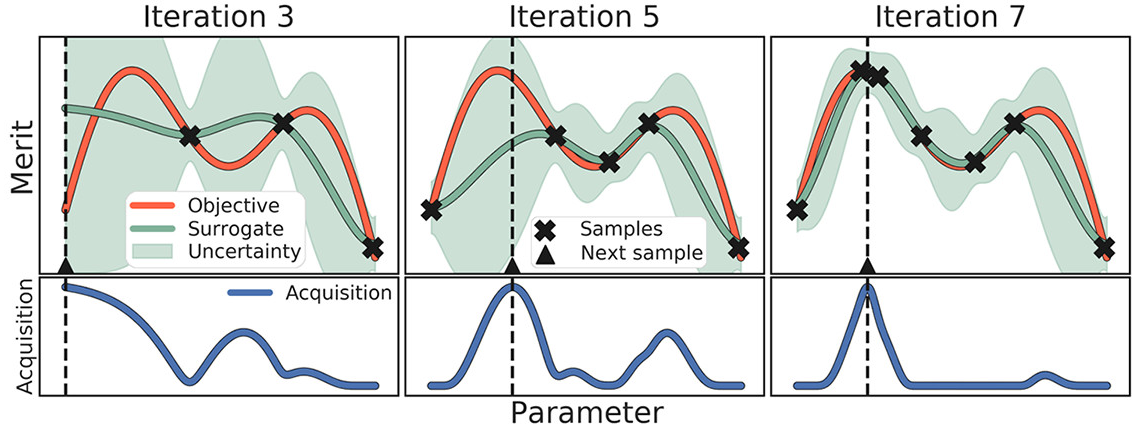

### Dataset

This dataset consists of 247 reactions that were carried out with the help of high-throughput screening. This dataset provides comprehensive information about the dependencies of the reaction yield of the Suzuki-Miyaura coupling against the reaction temperature and the amounts of the palladium precatalyst, the boronic acid ester, and potassium phosphate as the base. The reaction scheme is depicted below.

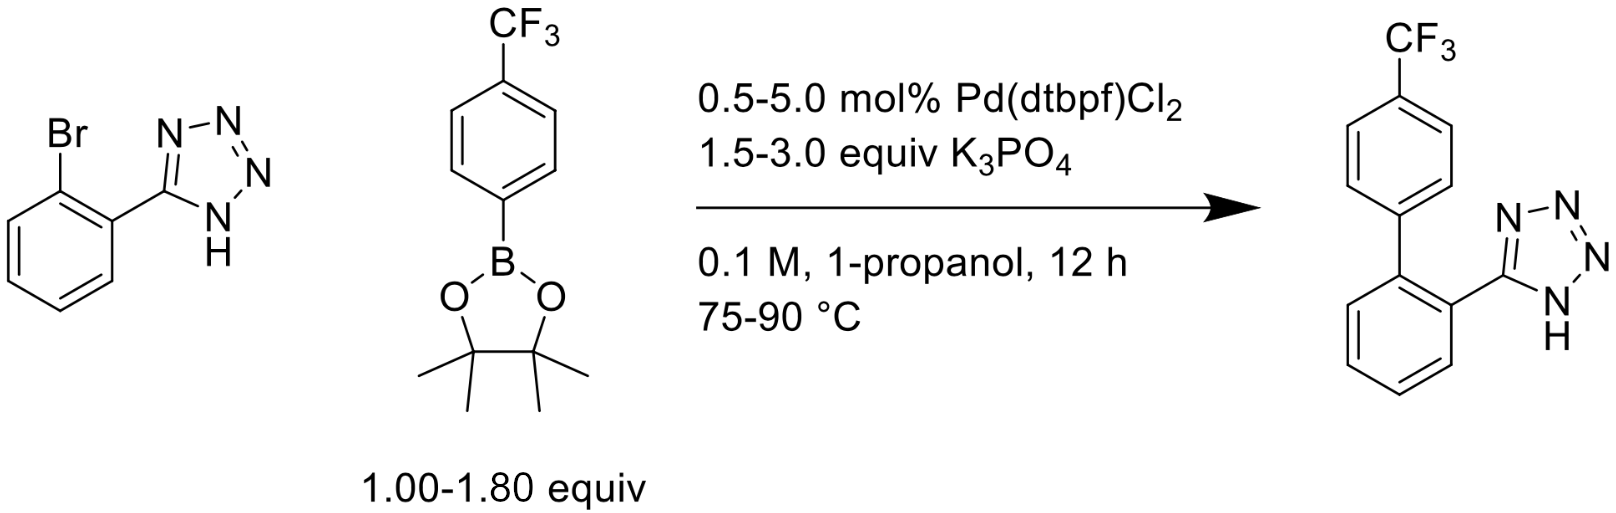

In the following line, we download the dataset from the GitHub repository of `olympus`.

In [ ]:
# Download dataset
! wget https://raw.githubusercontent.com/aspuru-guzik-group/olympus/refs/heads/main/src/olympus/datasets/dataset_suzuki/data.csv

Next, we load the data into python as a `DataFrame`. The data provides for each reaction conducted, the reaction temperature in °C, the amount of palladium precatalyst used in mol%, and the amounts of both boronic acid ester and potassium phosphate used in equivalents relative to the amount of the halide used, which is kept constant.

In [ ]:
# Load database from downloaded file
data_original = pd.read_csv('./data.csv', delimiter=',', names=['temperature', 'palladium', 'boron', 'base', 'yield'], header=None)
print(data_original)

Subsequently, we process the data for later use. Specifically, we scale the numerical values so that they all range from 0 to 1. This is done with the dedicated data scalers provided by the `scikit-learn` package. To scale the yield, we simply divide it by 100.

In [ ]:
# Process data from dataset
data = pd.DataFrame()
scaler_features = skpp.MinMaxScaler()
scaler_features.fit(data_original.loc[:,('temperature', 'palladium', 'boron', 'base')].values)
data.loc[:,('temperature', 'palladium', 'boron', 'base')] = scaler_features.transform(data_original.loc[:,('temperature', 'palladium', 'boron', 'base')].values)
data.loc[:,'yield'] = data_original.loc[:, 'yield'] / 100
print(data)

To demonstrate the capabilities of Bayesian optimization, we do not want to perform any experiments in the laboratory in this crash course. Rather, we will use the literature dataset to fit a Gaussian process regression model. This model is able to estimate the outcome of a planned experiment based on the reaction temperature, and the initial amounts of palladium precatalyst, boronic acid ester, and potassium phosphate. In this crash course, this model will serve as an emulator of the laboratory experiments. It will replace evaluation of the reaction performance that allows us to show the capabilities of Bayesian optimization in a convenient way.

This is implemented in the following code. Gaussian process regression is used via the `scikit-learn` package. It requires the data in a specific format to function properly. Gaussian process regression is based on a so-called kernel, also referred to as covariance function, that models how two sufficiently close points depend on each other. Here we use a combination of the radial basis function kernel and the white noise kernel.

Subsequently, we define the `emulator` object and fit it to the data from the `suzuki` dataset. Finally, we predict all the experimentally known yields with the trained Gaussian process regression model.

In [ ]:
# Reformat data
X = np.column_stack((data['temperature'].values.reshape(-1), data['palladium'].values.reshape(-1), data['boron'].values.reshape(-1), data['base'].values.reshape(-1)))
print(X)
Y = data['yield'].values.reshape(-1,1)

# Define Gaussian process regression model
kernel = (skgk.RBF() + skgk.WhiteKernel())
emulator = skg.GaussianProcessRegressor(kernel, normalize_y=True)

# Fit Gaussian process regression model to the experimental data
emulator.fit(X, Y)

# Predict the yields of all experimental points with Gaussian process regression
Y_predicted, Y_error = emulator.predict(X, return_std=True)

To get an idea about how good this model is, in the following code we plot the actual experimental yield against the predicted yield for the 247 datapoints of the original data. You can see that the agreement is quite good. Importantly, our emulator allows us to perform interpolation between the experimentally known points and estimate yields also for reaction conditions that have not been tested before.

In [ ]:
# Plot surrogate model predictions against actual values
#plt.scatter(Y_predicted, Y, label='Train')
plt.errorbar(Y_predicted, Y, xerr=Y_error, elinewidth=1, fmt="o", label='Emulator')
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', color='black', label='Ideal')
plt.legend()
plt.xlabel('Predicted Yield')
plt.ylabel('Experimental Yield')
plt.show()

For running the Bayesian optimization, we need to define a function that evaluates this Gaussian process regression based on the reaction parameters and returns the corresponding yield in a specific way as required by the `BayesianOptimization` package. This is done in the next code cell.

In [ ]:
# Define function that evaluates the yield based on the reaction parameters
def objective_function(temperature, palladium, boron, base):

  # Format model input
  X = np.column_stack((np.array(temperature).reshape(-1), np.array(palladium).reshape(-1), np.array(boron).reshape(-1), np.array(base).reshape(-1)))

  # Obtain model predictions
  Y_predicted = emulator.predict(X, return_std=False)[0]

  return(Y_predicted)

For performing the optimization, we assume that we know the reaction yield for one set of conditions. These conditions are quite poor and provide the desired product only in a yield of a few percent. So imagine that we ran this reaction under these conditions in the lab and discovered that the reaction works, but only with a low yield and now want to improve the conditions to maximize the yield. This is a typical situation in an organic chemistry lab. In the following code cell, `X_initial` defines these initial conditions, `Y_initial` is the corresponding product yield.

Subsequently, we define how many iterations we want to use for the Bayesian optimization, that is how many iterative cycles will we perform to test new reaction conditions and evaluate the corresponding product yields. Additionally, `parameter_bounds` defines the extreme values for all the reaction parameters we consider here. The dataset gives us some limitation here as we cannot expect the Gaussian process regression to perform reasonably well far outside the available datapoints. The parameters in the experimental dataset are within the following bounds, which we also respect for our Bayesian optimization:


*   Temperature: [75 °C, 90 °C]
*   Palladium precatalyst: [0.5 mol%, 5.0 mol%]
*   Boronic acid ester: [1.0 equiv., 1.8 equiv.]
*   Potassium phosphate: [1.5 equiv., 3.0 equiv.]



In [ ]:
# Starting point of optimization
X_initial = np.array([0.0, 0.0, 0.0, 0.0]).reshape(1,-1)
Y_initial = objective_function(0.0, 0.0, 0.0, 0.0)
print(f'{Y_initial:.2f}')

# Optimization parameters
iterations = 20
parameter_bounds = {'temperature': (0, 1),
                    'palladium': (0, 1),
                    'boron': (0, 1),
                    'base': (0, 1)}

With this, we have already completed everything we need to define. The next step is defining the Bayesian optimization object, which we call `optimizer`. Then, we provide the initial result that we already have to this object via its `register` class function. This is everything we need, now we are ready to run the optimization via the `maximize` class function. This now runs the actual Bayesian optimization. For 20 iterations, this is quite fast, however, if you want to try increasing this number, the optimization will take quite some time.

After the optimization is completed, we collect all the results, store it in a `DataFrame` object, transform the scaled experimental parameters back to the original number ranges, and print the results. In the printed table you can see in the left column the iteration number, the columns `temperature`, `palladium`, `boron`, and `base` provide the values of the reaction parameters tested at each iteration. The column `yield` provides the yield of the corresponding reaction. The column `best` is to keep track of the optimization progress and shows the value of the highest yield found during the Bayesian optimization until that point.

In [ ]:
# Define optimization object
optimizer = bo.BayesianOptimization(f=objective_function, pbounds=parameter_bounds, verbose=0)

# Register starting point of optimization
optimizer.register(params=X_initial, target=Y_initial)

# Run optimization
optimizer.maximize(init_points=1, n_iter=iterations)

# Collect optimization results
results = pd.DataFrame([ri['params'] for ri in optimizer.res])
results = results.loc[:, ['temperature', 'palladium', 'boron', 'base']]
results.loc[:,:] = scaler_features.inverse_transform(results.values)
results['yield'] = [ri['target'] for ri in optimizer.res]
results['best'] = [max(results['yield'].values[0:ni+1]) for ni in range(len(results.index))]

# Print optimization progress
print(results)

It is also insightful to illustrate the optimization progress in a plot. This is implemented in the following code cell.

In [ ]:
# Plot surrogate model predictions against actual values
ax = plt.figure().gca()
ax.xaxis.set_major_locator(tck.MaxNLocator(integer=True))
ax.plot(results.index, results['best'], linestyle='-', color='black', label='Best Experiment')
ax.plot(results.index, results['yield'], linestyle='-', color='red', label='Current Experiment')
ax.legend()
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Reaction Yield')
plt.show()

With this, we are already finished with the Bayesian optimization. You can see that it found very good reaction conditions very quickly. Admittedly, this particular reaction is not extremely challenging to optimize as simply increasing the temperature and the amounts of palladium precatalyst, boronic acid ester, and potassium phosphate leads to very good yields.

Now you might wonder how this approach could be actually applied to the lab. We already knew the dependencies of the yield on the reaction conditions beforehand and then fitted a Gaussian process regression to emulate the experiments. This is not what you would do when you actually want to optimize a new reaction. For this, rather than using Gaussian process regression to obtain the reaction yield for a specific set of conditions, you would want to perform an experiment in the lab. This can be implemented quite easily with the `BayesianOptimization` package.

In the following code cells, we implement an interactive optimization loop. That is, we perform only one step at a time. We use Bayesian optimization to propose one set of reaction conditions each time. These conditions can then, in principle, be tested in the lab. For convenience, we will use agaion our Gaussian process regression, but you could actually test these conditions in the lab, determine the product yield, and come back to the computer and provide the outcome to the Bayesian optimization algorithm. This updates the model that is learned by the algorithm and allows to propose new experimental conditions.

The optimization loop implemented below follows the following 6 steps:
1.   Use Bayesian optimization to propose reaction conditions to be performed.
2.   Perform the experiment testing the proposed reaction conditions. In this notebook, this means that we use the `objective_function` to estimate the yield for a set of proposed reaction conditions.
3.   Provide the outcome of the proposed experiment to the `iterative_optimizer` via the `register` class function.
4.   Print the optimization progress from the beginning up to the current point (optional).
5.   Illustrate the optimization progress from the beginning up to the current point (optional).
6.   Go back to point 1 to perform another optimization cycle until you are satisfied with the result.

The starting point is again the definition of a new Bayesian optimization object called `iterative_optimizer`. The key change to before is that now we do not provide a function that allows evaluating the outcome of an experiment by defining `f=None`. Again, we `register` the first datapoint which we already know from initial experiments.



In [ ]:
# Define optimization object
iterative_optimizer = bo.BayesianOptimization(f=None, pbounds=parameter_bounds, verbose=0, random_state=2)

# Register starting point of optimization
iterative_optimizer.register(params=X_initial, target=Y_initial)

Here is now the first step of the optimization loop:

**1. Use Bayesian optimization to propose reaction conditions to be performed.**

As you can see, we simple use the `iterative_optimizer` to suggest conditions and then use `scaler_features` to transform the values to the original scale. The suggested experiment is printed so you could literally go to the lab and perform this experiment.

In [ ]:
# Suggest point to evaluate
proposed_experiment = iterative_optimizer.suggest()
proposed_experiment_unscaled = scaler_features.inverse_transform(pd.DataFrame([proposed_experiment]).loc[:, ['temperature', 'palladium', 'boron', 'base']].values)
print(f"The next experiment to perform is: Temperature {proposed_experiment_unscaled[0, 0]:.0f} °C, Palladium Amount {proposed_experiment_unscaled[0, 1]:.2f} mol%, Boronic Acid Ester Amount {proposed_experiment_unscaled[0, 2]:.2f} equiv., Potassium phosphate {proposed_experiment_unscaled[0, 3]:.2f} equiv.", )

Next, the second step:

**2.   Perform the experiment testing the proposed reaction conditions.**

This is the step where you would actually go to the lab and test the proposed reaction conditions to determine the corresponding product yield. In this notebook, we simply use the `objective_function`, which relies on the Gaussian process regression model to estimate the product yield for the proposed reaction conditions.

In [ ]:
# Evaluate proposed experiment with surrogate function
experiment_outcome = objective_function(**proposed_experiment)
print(f"The yield of the proposed experiment is: {experiment_outcome:.3f}")

Subsequently, the third and last required step in the loop:

**3.   Provide the outcome of the proposed experiment to the `iterative_optimizer` via the `register` class function.**

If you wanted to use this code for an actual reaction optimization in the lab, you would simply need to replace `experiment_outcome` with the experimentally determined yield.

In [ ]:
# Provide outcome of proposed experiment to the optimization algorithm
iterative_optimizer.register(params=proposed_experiment, target=experiment_outcome)

Now, for the fourth step:

**4.   Print the optimization progress from the beginning up to the current point (optional).**

It is always good to summarize what has happened so far and check how the optimization is progressing. However, this step is technically not required in the optimization loop.

In [ ]:
# Collect optimization results
results = pd.DataFrame([ri['params'] for ri in iterative_optimizer.res])
results = results.loc[:, ['temperature', 'palladium', 'boron', 'base']]
results.loc[:,:] = scaler_features.inverse_transform(results.values)
results['yield'] = [ri['target'] for ri in iterative_optimizer.res]
results['best'] = [max(results['yield'].values[0:ni+1]) for ni in range(len(results.index))]

# Print optimization progress
print(results)

The fifth and final step in the optimization loop is the following:

**5.   Illustrate the optimization progress from the beginning up to the current point (optional).**

Again, this is optional but it is always good to visualize what is happening in an optimization.

In [ ]:
# Plot surrogate model predictions against actual values
ax = plt.figure().gca()
ax.xaxis.set_major_locator(tck.MaxNLocator(integer=True))
ax.plot(results.index, results['best'], linestyle='-', color='black', label='Best Experiment')
ax.plot(results.index, results['yield'], linestyle='-', color='red', label='Current Experiment')
ax.legend()
ax.set_xlabel('Iteration Number')
ax.set_ylabel('Reaction Yield')
plt.show()

With this, we are at the end of the loop and we simply need to do the following:

**6.   Go back to point 1 to perform another optimization cycle until you are satisfied with the result.**

With this, we are already at the end of this crash course on Bayesian optimizatoin. Feel free to use this code for your own experimental optimization campaign.